In [3]:
!pip3 install mplfinance
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpl
import datetime as dt

In [5]:
currency='INR'
metric='Close'

start=dt.datetime(2019,1,1)
end=dt.datetime.now()

crypto=['BTC','ETH','USDT','DASH','BNB','SOL']
colnames=[]
first=True

In [6]:
import yfinance as yf
for ticker in crypto:
  data=yf.download(f'{ticker}-{currency}', start=start, end=end)
  if first:
    combined=data[[metric]].copy()
    colnames.append(ticker)
    combined.columns=colnames
    first=False
  else:
    combined=combined.join(data[metric])
    colnames.append(ticker)
    combined.columns=colnames

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


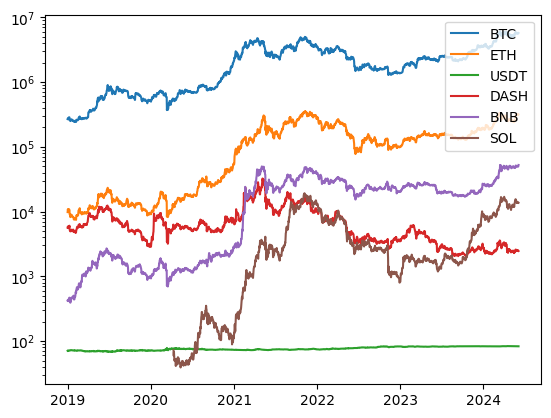

In [7]:
plt.yscale('log')
for ticker in crypto:
  plt.plot(combined[ticker],label=ticker)
plt.legend(loc='upper right')
plt.show()

<Axes: >

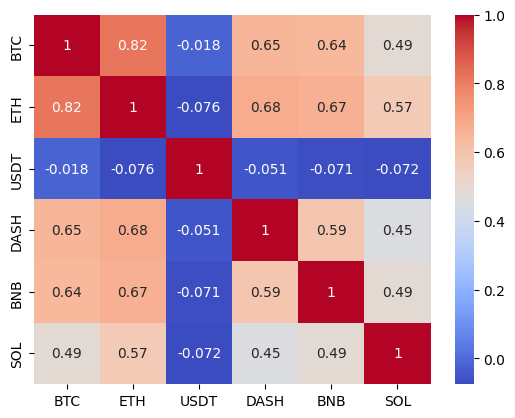

In [8]:
combined=combined.pct_change().corr(method='pearson')
sns.heatmap(combined,annot=True,cmap='coolwarm')

**Predicting BTC-INR prices using neural networks**

In [9]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential

In [10]:
cryptoc='BTC'
against='INR'
data=yf.download(f'{cryptoc}-{against}', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [11]:
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days=60
x_train,y_train=[],[]
for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train

array([[[0.00441582],
        [0.00578759],
        [0.0045794 ],
        ...,
        [0.00547678],
        [0.00526541],
        [0.00544476]],

       [[0.00578759],
        [0.0045794 ],
        [0.0044468 ],
        ...,
        [0.00526541],
        [0.00544476],
        [0.00550445]],

       [[0.0045794 ],
        [0.0044468 ],
        [0.00429895],
        ...,
        [0.00544476],
        [0.00550445],
        [0.00529383]],

       ...,

       [[0.95875621],
        [0.89697479],
        [0.90489471],
        ...,
        [0.93615401],
        [0.92772216],
        [0.93848341]],

       [[0.89697479],
        [0.90489471],
        [0.94243679],
        ...,
        [0.92772216],
        [0.93848341],
        [0.92758089]],

       [[0.90489471],
        [0.94243679],
        [0.93064136],
        ...,
        [0.93848341],
        [0.92758089],
        [0.93067612]]])

In [12]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
61/61 [==============================] - 33s 236ms/step - loss: 0.0176
Epoch 2/25
61/61 [==============================] - 9s 147ms/step - loss: 0.0035
Epoch 3/25
61/61 [==============================] - 5s 83ms/step - loss: 0.0035
Epoch 4/25
61/61 [==============================] - 6s 106ms/step - loss: 0.0029
Epoch 5/25
61/61 [==============================] - 5s 80ms/step - loss: 0.0027
Epoch 6/25
61/61 [==============================] - 7s 108ms/step - loss: 0.0032
Epoch 7/25
61/61 [==============================] - 5s 86ms/step - loss: 0.0025
Epoch 8/25
61/61 [==============================] - 5s 88ms/step - loss: 0.0024
Epoch 9/25
61/61 [==============================] - 7s 110ms/step - loss: 0.0026
Epoch 10/25
61/61 [==============================] - 5s 86ms/step - loss: 0.0023
Epoch 11/25
61/61 [==============================] - 7s 115ms/step - loss: 0.0057
Epoch 12/25
61/61 [==============================] - 5s 85ms/step - loss: 0.0023
Epoch 13/25
61/61 [===========

In [13]:
test_start=dt.datetime(2024,1,1)
test_end=dt.datetime.now()
test_data=data=yf.download(f'{cryptoc}-{against}', start=test_start, end=test_end)
actual_prices=test_data['Close'].values

import pandas as pd

total_dataset=pd.concat((data['Close'],test_data['Close']),axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scaler.fit_transform(model_inputs)

[*********************100%%**********************]  1 of 1 completed


In [14]:
x_test=[]
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [15]:
prediction_prices=model.predict(x_test)
prediction_prices=scaler.inverse_transform(prediction_prices)

5/5 [==============================] - 2s 30ms/step


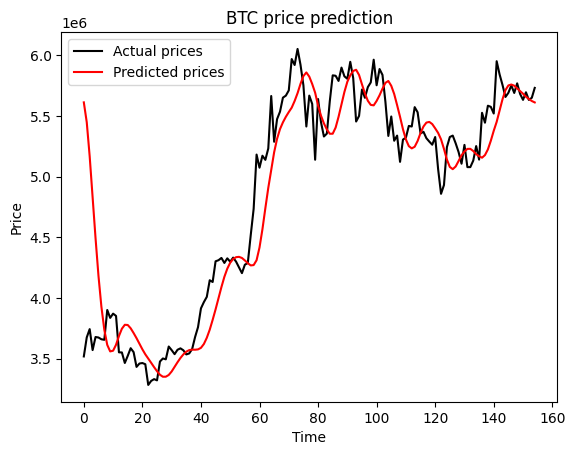

In [16]:
plt.plot(actual_prices,label="Actual prices",color='black')
plt.plot(prediction_prices,label="Predicted prices",color='red')
plt.title(f'{cryptoc} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [22]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(actual_prices, predicted_prices):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_prices, predicted_prices)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_prices, predicted_prices)

    # R-squared (R2) Score
    r2 = r2_score(actual_prices, predicted_prices)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return mse, mae, r2, mape, rmse

# Example of how to use evaluate_model function
mse, mae, r2, mape, rmse = evaluate_model(actual_prices, prediction_prices)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 138152622828.47943
Mean Absolute Error (MAE): 240391.67580645162
R-squared (R2) Score: 0.825813040752674
Mean Absolute Percentage Error (MAPE): 21.55446865664351
Root Mean Squared Error (RMSE): 371688.8790756046
